In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import datetime

In [2]:
dataF = pd.read_csv("matala2_cosmetics_2019-Nov2.csv")
data = dataF[0:200].copy()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---

Q1

In [3]:
data['event_time']= pd.to_datetime(data['event_time'])

In [4]:
data['DateTime'] = pd.to_datetime(data['event_time'], format='%Y-%m-%d %H:%M:%S.%f')
data['Date'] = pd.to_datetime(data['DateTime'].dt.date)
data['Time'] = pd.to_datetime(data['DateTime'].dt.time, format='%H:%M:%S')

In [5]:
data['Time2'] = data.groupby(['user_session'])['Time'].shift(-1).fillna(data['Time'])
data['duration_to_next_event'] = (data['Time2']- data['Time']).dt.seconds

----

Q2

In [6]:
data['Date2'] = data.groupby(['user_id'])['Date'].shift(1).fillna(data['Date']) # fillna for the first visit

In [7]:
data['0_1'] = (data['Date'] - data['Date2']).dt.days.apply(lambda x: 1 if x > 5 else 0)

In [8]:
data['funnel_number']=data.groupby(['user_id'])['0_1'].cumsum()+1

----

Q3

In [9]:
data_copy= data.copy()
data_copy.drop_duplicates(subset='user_session', inplace=True)

In [10]:
data_copy['index_in_funnel'] = data_copy.groupby(['user_id','funnel_number'])['user_session'].cumcount() + 1
data_copy =data_copy[['user_session','index_in_funnel']]

In [11]:
data = pd.merge(data, data_copy, on='user_session')

----

Q4

In [12]:
def numPrice(x):
    price = re.findall('\S*[0-9]\S*', x)
    res = price[0]
    return float(res)
data['price']=data['price'].apply(numPrice) 


------

Q5

In [13]:
pd.unique(data['event_type'])

array(['view', 'cart', 'remove_from_cart', 'purchase'], dtype=object)

<AxesSubplot:xlabel='event_type', ylabel='count'>

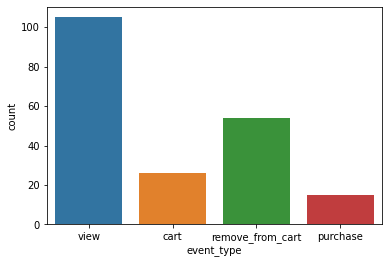

In [14]:
sns.countplot(x='event_type', data=data)

------

Q6

In [15]:
session_data=data.copy()

In [16]:
session_data['number_of_event'] = session_data.groupby(['user_session'])['event_type'].transform('count')

In [17]:
dataG=data.groupby('user_session')
dataG_totalTime=dataG['Time'].max()-dataG['Time'].min()
session_data = pd.merge(session_data, dataG_totalTime, on='user_session')

In [18]:
data_list= session_data.groupby(['user_session','event_type']).agg({
    'product_id': lambda x: list(x)}).reset_index()
pt = pd.pivot_table(data_list, index = 'user_session', columns = 'event_type', values = 'product_id',aggfunc='first').reset_index()
session_data = pd.merge(session_data, pt, on='user_session')

In [20]:
session_data=session_data[['user_id','user_session','funnel_number','number_of_event','Time_y','view','cart','purchase','index_in_funnel']]   

In [21]:
session_data = session_data.rename(columns={'Time_y': 'Total_tinme'})


In [22]:
session_data.drop_duplicates(subset='user_session', inplace=True)